# Credit Card Default — Summary

**Dataset:** UCI “Default of Credit Card Clients”.  
**Target:** `default payment next month` (0/1).  
**Goal:** Predict likelihood of default and compare classic ML models.

**Models evaluated:** Logistic Regression (scaled), Random Forest, XGBoost.  
**Headline results (test set):**
- Best: **Random Forest (tuned)** — **Accuracy ≈ 0.82**, **Recall (default class) ≈ 0.35**.
- Baselines: Logistic Regression — **Acc ≈ 0.81**, Recall ≈ 0.24; XGBoost — **Acc ≈ 0.81**, Recall ≈ 0.36.

**Notes**
- Stratified train/test split to preserve class ratio (dataset is imbalanced).
- Metrics: Accuracy, Precision, Recall, F1; confusion matrices included.
- Reproducibility: `random_state=42` used for data split and models.

**Next steps**
- Threshold tuning or class weights to improve default-class recall.
- Add ROC–AUC / PR curves; (optional) feature importance or SHAP for tree models.


## Load and Prepare Dataset

In [53]:
# Import Libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Load and Prepare Data 
def load_and_prepare_data():
    df_raw = pd.read_csv("default of credit card clients 3.csv")
    df_raw.columns = df_raw.iloc[0]
    df = df_raw[1:].reset_index(drop=True)

    column_mapping = {
        'X1': 'LIMIT_BAL', 'X2': 'SEX', 'X3': 'EDUCATION', 'X4': 'MARRIAGE',
        'X5': 'AGE', 'X6': 'PAY_0', 'X7': 'PAY_2', 'X8': 'PAY_3', 'X9': 'PAY_4',
        'X10': 'PAY_5', 'X11': 'PAY_6', 'X12': 'BILL_AMT1', 'X13': 'BILL_AMT2',
        'X14': 'BILL_AMT3', 'X15': 'BILL_AMT4', 'X16': 'BILL_AMT5', 'X17': 'BILL_AMT6',
        'X18': 'PAY_AMT1', 'X19': 'PAY_AMT2', 'X20': 'PAY_AMT3', 'X21': 'PAY_AMT4',
        'X22': 'PAY_AMT5', 'X23': 'PAY_AMT6', 'Y': 'default_payment_next_month'
    }
    
    df = df.rename(columns=column_mapping) 
    df = df.drop(columns=['ID'], errors='ignore') # Drop 'ID', and convert all columns to numeric
    df = df.apply(pd.to_numeric)
    
    return df

df = load_and_prepare_data()
print(df.shape)
df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## DATA EXPLORATION – summary statistics, types, missing values,outliers

In [56]:
# Summary Statistics
def display_summary_statistics(df):
    print("\nSummary Statistics:")  # Display summary statistics for numerical columns
    print(df.describe())

# Data Types and Non-Null Counts
def display_data_types(df):
    print("\nData Types and Non-Null Counts:")  # Display data types and non-null counts
    print(df.info())

#  Missing Values Check
def check_missing_values(df):
    print("\nMissing Values per Column:")  # Print the number of missing values
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

# Outlier Detection using IQR
def detect_outliers_iqr(df, columns=None):
    print("\nOutlier Detection (IQR Method):")
    outlier_counts = {}
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_counts[col] = len(outliers)
        print(f"{col}: {len(outliers)} potential outliers")
    return outlier_counts
    
# Load data
df = load_and_prepare_data()

# Data Exploration
display_summary_statistics(df)
display_data_types(df)
check_missing_values(df)
detect_outliers_iqr(df)


Summary Statistics:
0           LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

0             PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1

{'LIMIT_BAL': 167,
 'SEX': 0,
 'EDUCATION': 454,
 'MARRIAGE': 0,
 'AGE': 272,
 'PAY_0': 3130,
 'PAY_2': 4410,
 'PAY_3': 4209,
 'PAY_4': 3508,
 'PAY_5': 2968,
 'PAY_6': 3079,
 'BILL_AMT1': 2400,
 'BILL_AMT2': 2395,
 'BILL_AMT3': 2469,
 'BILL_AMT4': 2622,
 'BILL_AMT5': 2725,
 'BILL_AMT6': 2693,
 'PAY_AMT1': 2745,
 'PAY_AMT2': 2714,
 'PAY_AMT3': 2598,
 'PAY_AMT4': 2994,
 'PAY_AMT5': 2945,
 'PAY_AMT6': 2958,
 'default payment next month': 6636}

## Check and fix invalid EDUCATION entries

In [59]:
#  Check for invalid EDUCATION values
def check_invalid_education_values(df):
    valid_values = [1, 2, 3, 4]
    invalid_rows = df[~df['EDUCATION'].isin(valid_values)]
    if not invalid_rows.empty:
        print("\nInvalid EDUCATION values found:")
        print(invalid_rows[['EDUCATION']].value_counts())
    else:
        print("\nNo invalid EDUCATION values found.")
    return invalid_rows
    
# Investigate EDUCATION "outliers" 
invalid_education_entries = check_invalid_education_values(df)

#  Fix EDUCATION values by replacing invalids with '4' (Others)
def fix_invalid_education_as_others(df):
    print("\nFixed invalid EDUCATION values by recoding them to '4' (Others).")
    df['EDUCATION'] = df['EDUCATION'].apply(lambda x: x if x in [1, 2, 3, 4] else 4)
    return df

# Based on findings
if not invalid_education_entries.empty:
    df = fix_invalid_education_as_others(df)
    
#During data exploration, the `EDUCATION` column was found to contain values outside the expected range (1 = Graduate School, 2 = University, 3 = High School, 4 = Others). Specifically, values such as `0`, `5`, and `6` were identified. 
#These were not true statistical outliers but rather invalid categorical entries. 
#These values were recoded to `4 (Others)` to preserve the data while maintaining categorical integrity.


Invalid EDUCATION values found:
EDUCATION
5            280
6             51
0             14
Name: count, dtype: int64

Fixed invalid EDUCATION values by recoding them to '4' (Others).


## Investigate negative billing amounts

In [62]:
# Negative Billing Amounts (BILL_AMT4 to BILL_AMT6)
def investigate_negative_bills(df):
    print("\nInvestigating Negative Bill Amounts (BILL_AMT4 to BILL_AMT6):")
    bill_cols = ['BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    pay_cols = ['PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']
    condition = (df['BILL_AMT4'] < 0) | (df['BILL_AMT5'] < 0) | (df['BILL_AMT6'] < 0)
    relevant_rows = df.loc[condition, bill_cols + pay_cols]
    print(relevant_rows.head())  # Display first few for review
   
# Investigate negative billing behavior
investigate_negative_bills(df)


#Several rows contained negative values in the billing amount columns `BILL_AMT4`, `BILL_AMT5`, and `BILL_AMT6`. To understand this, these rows were compared with their corresponding monthly payments (`PAY_AMT2` to `PAY_AMT5`). 
#Observation: Many clients with negative bill amounts continued making payments, and in some cases, made large payments following those negative balances.
#Conclusion:These negative values are likely due to legitimate account behaviors such as overpayments, refunds, or account credits—not data entry errors.
#Decision:The negative values were retained in the dataset as they may carry important signals for modeling.


Investigating Negative Bill Amounts (BILL_AMT4 to BILL_AMT6):
0   BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5
7         221       -159        567       601         0       581      1687
26        -57        127       -189      1000         0       500         0
35       -923      -1488      -1884       396       396       565       792
37       6026     -28335      18660      1518      2043         0     47671
56       7142       -679       8321      1500      7500       679      9000


## Encode Categorical Variables


In [65]:
# Step 1: Encode categorical variables
def encode_categoricals(df):
    return pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True, dtype=int)

df_encoded = encode_categoricals(df)

#  Step 2: Saving the unnormalized version for Random Forest, XGBoost
df_encoded.to_csv("cleaned_dataset_NOT_Normalized.csv", index=False)


## Normalize Numerical Features

In [68]:
#  Step 4: Normalize numeric features 
def normalize_numerical_features(df, target_column='default payment next month'):
    # Exclude target and dummy variables (which are binary)
    cols_to_exclude = [target_column] + [col for col in df.columns if df[col].nunique() <= 2]
    numeric_cols = df.select_dtypes(include='number').drop(columns=cols_to_exclude)

    scaler = StandardScaler()
    df[numeric_cols.columns] = scaler.fit_transform(df[numeric_cols.columns])
    return df

df_normalized = normalize_numerical_features(df_encoded.copy())  # Using a copy to avoid modifying the original
df_normalized.to_csv("cleaned_dataset_normalized.csv", index=False)

In [70]:
# Load both datasets
df_raw = pd.read_csv("cleaned_dataset_NOT_Normalized.csv")
df_norm = pd.read_csv("cleaned_dataset_normalized.csv")

# Display shape and column headers
print("🟩 Raw (Unnormalized) Dataset:")
print(df_raw.shape)
display(df_raw.head())

print("\n🟦 Normalized Dataset:")
print(df_norm.shape)
display(df_norm.head())

🟩 Raw (Unnormalized) Dataset:
(30000, 28)


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT5,PAY_AMT6,default payment next month,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,1,1,1,0,0,1,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,2000,1,1,1,0,0,0,1,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,1000,5000,0,1,1,0,0,0,1,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,1069,1000,0,1,1,0,0,1,0,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,689,679,0,0,1,0,0,1,0,0



🟦 Normalized Dataset:
(30000, 28)


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT5,PAY_AMT6,default payment next month,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.314136,-0.293382,1,1,1,0,0,1,0,0
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.314136,-0.180878,1,1,1,0,0,0,1,0
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,-0.248683,-0.012122,0,1,1,0,0,0,1,0
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.244166,-0.237130,0,1,1,0,0,1,0,0
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,-0.269039,-0.255187,0,0,1,0,0,1,0,0


## K-means and DSBAN Clustering

In [74]:
# 2.1 Import Libraries 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 2.2  === Load Cleaned Dataset ===
df_norm.to_csv("cleaned_dataset_normalized.csv", index=False)
def kmeans_pipeline(df, target_column='default payment next month', max_k=10):
   
    # 2.3: Drop target column
    df_cluster = df.drop(columns=[target_column])  

    # 2.4: Elbow Method
    inertia = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_cluster)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

    # Choose optimal k 
    optimal_k = int(input("Enter the optimal number of clusters (k): "))

    # 2.5 Apply K-Means method
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans_final.fit_predict(df_cluster)

    # 2.6 Evaluate using Silhouette Score
    score = silhouette_score(df_cluster, df['Cluster'])
    print(f"Silhouette Score for k={optimal_k}: {score:.4f}")

    # 2.7 PCA for Visualization
    pca = PCA(n_components=2)
    components = pca.fit_transform(df_cluster)
    df['PCA1'] = components[:, 0]
    df['PCA2'] = components[:, 1]

    # 2.8 Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=60)
    plt.title(f'K-Means Clusters (k={optimal_k}) in 2D PCA Space')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    return df

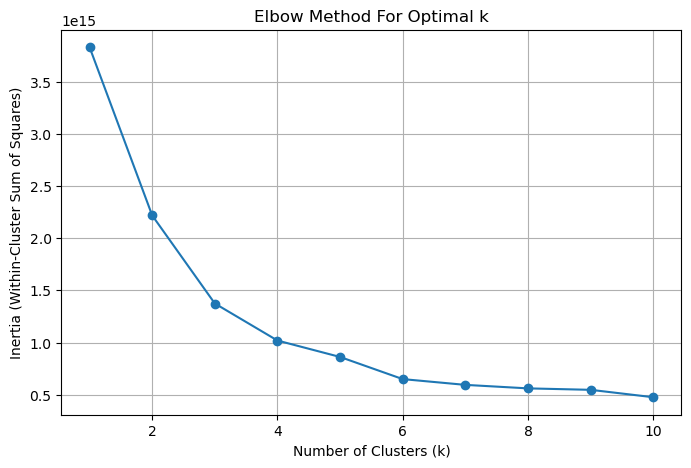

Enter the optimal number of clusters (k):  5


Silhouette Score for k=5: 0.4336


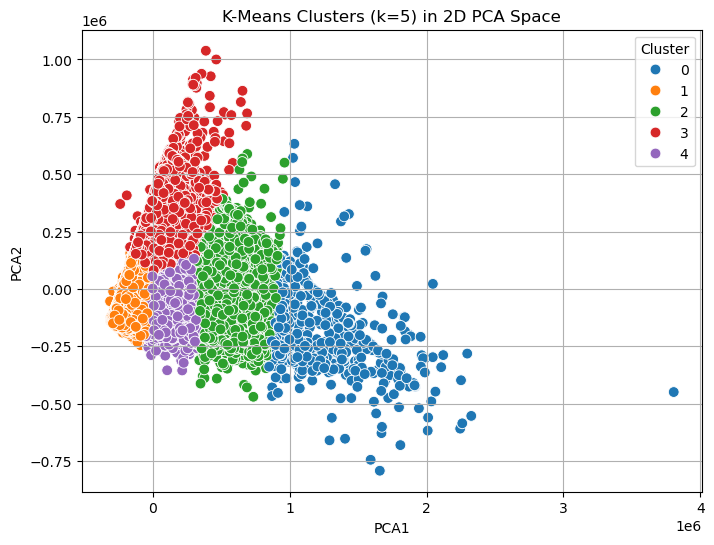

In [79]:
# df is the cleaned Task 1 dataset
df_clustered = kmeans_pipeline(df)

In [81]:
# Group by 'Cluster' and calculate mean for each numerical feature
cluster_summary = df_clustered.groupby('Cluster').mean(numeric_only=True).round(2)

cluster_summary = cluster_summary.drop(columns=['PCA1', 'PCA2'], errors='ignore')

print("Cluster Summary from Cleaned Dataset:")
print(cluster_summary)

Cluster Summary from Cleaned Dataset:
0        LIMIT_BAL   SEX  EDUCATION  MARRIAGE    AGE  PAY_0  PAY_2  PAY_3  \
Cluster                                                                     
0        410226.82  1.55       1.68      1.49  38.70   0.35   0.28   0.24   
1         81094.70  1.60       1.94      1.59  34.52   0.08  -0.03  -0.07   
2        270650.74  1.57       1.80      1.51  36.66   0.26   0.25   0.21   
3        327976.71  1.63       1.58      1.47  37.20  -0.64  -0.89  -0.90   
4        140533.96  1.62       1.93      1.55  35.22   0.35   0.33   0.30   

0        PAY_4  PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
Cluster                ...                                              
0         0.17   0.14  ...  315626.90  292812.02  278953.86  19747.16   
1        -0.15  -0.21  ...   16068.97   14823.01   14396.83   2889.98   
2         0.17   0.14  ...  159832.84  148201.31  141152.99  14601.20   
3        -0.91  -0.92  ...   15460.25   15168.79   15189.

In [84]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


def dbscan_with_pca_and_auto_eps(df, min_samples=4):
    """
    Apply PCA to reduce dimensionality, then run DBSCAN with optimal eps.

    Returns:
        DataFrame with cluster labels and PCA columns.
    """
    # Select only columns with >2 unique values (exclude dummies)
    df_cluster = df[[col for col in df.columns if df[col].nunique() > 2]]
    
    # Scale and apply PCA
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_cluster)

    # Set n_components based on available features
    max_components = min(scaled.shape[1], 5)
    pca = PCA(n_components=max_components)
    pca_data = pca.fit_transform(scaled)

    # Search for best eps
    eps_values = np.linspace(0.5, 5, 20)
    best_score = -1
    best_eps = None
    best_labels = None

    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(pca_data)
        if len(set(labels)) > 1 and len(set(labels)) < len(pca_data):
            score = silhouette_score(pca_data, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels

    # Attach results to df
    df['DBSCAN_Cluster'] = best_labels
    df['PCA1'] = pca_data[:, 0]
    df['PCA2'] = pca_data[:, 1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10', s=60)
    plt.title(f"DBSCAN Clustering with PCA (Best eps = {best_eps:.2f})")
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    print(f"✅ Best eps: {best_eps:.2f} | Silhouette Score: {best_score:.4f}")
    return df

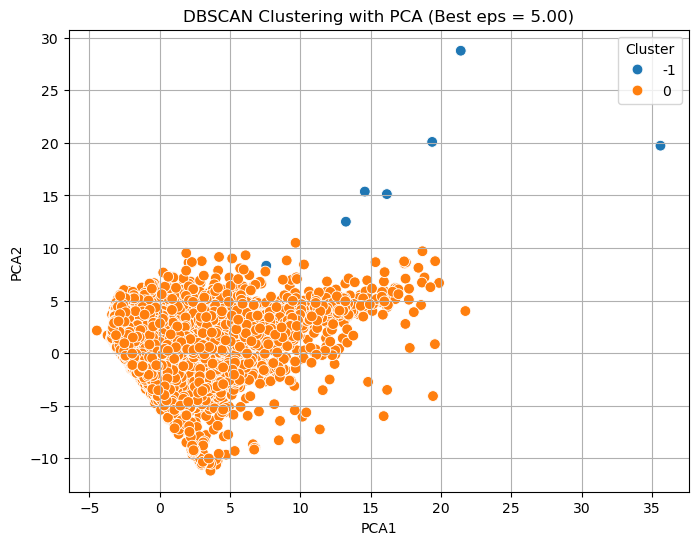

✅ Best eps: 5.00 | Silhouette Score: 0.8886


In [86]:
df = dbscan_with_pca_and_auto_eps(df)

In [92]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

# --- Helper to print consistent metrics ---
def evaluate(model, X, y, name):
    y_pred = model.predict(X)
    print(f"\n{name} Predictions Count:")
    counts = pd.Series(y_pred).value_counts().sort_index()
    print(counts)
    print(f"Positive rate: {counts.get(1, 0) / len(y_pred):.3f}")

    print("\nClassification report:")
    print(classification_report(y, y_pred, digits=3))

    try:
        cm = confusion_matrix(y, y_pred, labels=[0, 1])
        print("Confusion matrix [[TN FP]\n                  [FN TP]]:")
        print(cm)
    except Exception as e:
        print(f"Confusion matrix error: {e}")

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
        try:
            print(f"ROC-AUC: {roc_auc_score(y, y_proba):.3f}")
        except Exception as e:
            print(f"ROC-AUC error: {e}")

# --- Logistic Regression (normalized features) ---
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"   # boosts recall on minority class
)
log_model.fit(X_train_norm, y_train)
evaluate(log_model, X_test_norm, y_test, "Logistic Regression")

# --- Random Forest (raw features) ---
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,                # small regularization
    max_features="sqrt",
    class_weight="balanced_subsample", # handle imbalance
    random_state=42,                   # reproducible
    n_jobs=-1
)
rf_model.fit(X_train_raw, y_train)
evaluate(rf_model, X_test_raw, y_test, "Random Forest")

# --- XGBoost (raw features) ---
# ratio of negatives to positives in training set (guard against zero positives)
pos = int(y_train.sum())
neg = len(y_train) - pos
ratio = neg / max(pos, 1)

xgb_model = XGBClassifier(
    eval_metric="logloss",
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,     
    n_jobs=-1,           
    tree_method="hist",  
    scale_pos_weight=ratio  
)
xgb_model.fit(X_train_raw, y_train)
evaluate(xgb_model, X_test_raw, y_test, "XGBoost")



Logistic Regression Predictions Count:
0    5589
1    3411
Name: count, dtype: int64
Positive rate: 0.379

Classification report:
              precision    recall  f1-score   support

           0      0.871     0.694     0.773      7009
           1      0.372     0.637     0.470      1991

    accuracy                          0.682      9000
   macro avg      0.621     0.666     0.621      9000
weighted avg      0.760     0.682     0.706      9000

ROC-AUC: 0.717

Random Forest Predictions Count:
0    7624
1    1376
Name: count, dtype: int64
Positive rate: 0.153

Classification report:
              precision    recall  f1-score   support

           0      0.849     0.924     0.885      7009
           1      0.610     0.422     0.499      1991

    accuracy                          0.813      9000
   macro avg      0.730     0.673     0.692      9000
weighted avg      0.796     0.813     0.799      9000

ROC-AUC: 0.771

XGBoost Predictions Count:
0    6460
1    2540
Name: count,

In [93]:
# Logistic Regression - used normalized data
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_norm, y_train)
log_preds = log_model.predict(X_test_norm)
print("Logistic Regression Predictions Count:")
print(pd.Series(log_preds).value_counts())

# Random Forest - used unnormalized data
rf_model = RandomForestClassifier( n_estimators=300,
    max_depth=None,
    random_state=42,  
    n_jobs=-1)
rf_model.fit(X_train_raw, y_train)
rf_preds = rf_model.predict(X_test_raw)
print("\nRandom Forest Predictions Count:")
print(pd.Series(rf_preds).value_counts())

# XGBoost - also used unnormalized data
xgb_model = XGBClassifier(eval_metric='logloss', n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42       )
xgb_model.fit(X_train_raw, y_train)
xgb_preds = xgb_model.predict(X_test_raw)
print("\nXGBoost Predictions Count:")
print(pd.Series(xgb_preds).value_counts())


Logistic Regression Predictions Count:
0    8317
1     683
Name: count, dtype: int64

Random Forest Predictions Count:
0    7870
1    1130
Name: count, dtype: int64

XGBoost Predictions Count:
0    7917
1    1083
Name: count, dtype: int64


In [96]:

print("Logistic Regression Performance:")
print(classification_report(y_test, log_preds))

print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_preds))


print("\nXGBoost Classification Performance:")
print(classification_report(y_test, xgb_preds))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.36      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.61      0.62      9000
weighted avg       0.79      0.81      0.77      9000


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.64      0.36      0.46      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.65      0.68      9000
weighted avg       0.80      0.81      0.79      9000


XGBoost Classification Performance:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.65      0.36      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.75      0

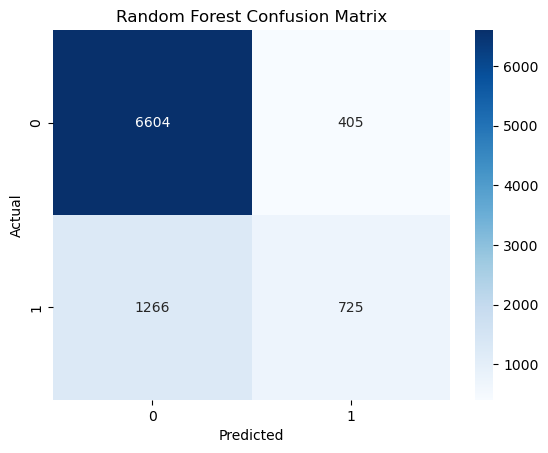

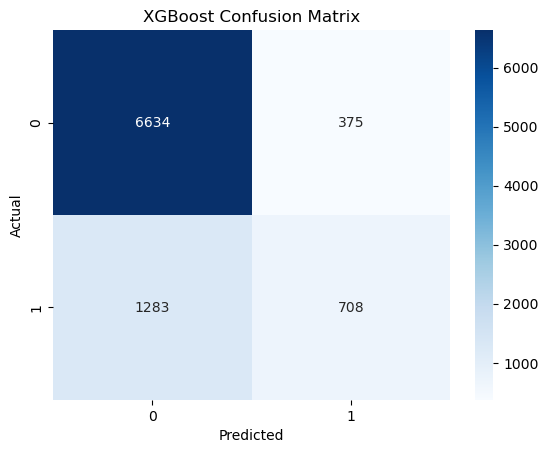

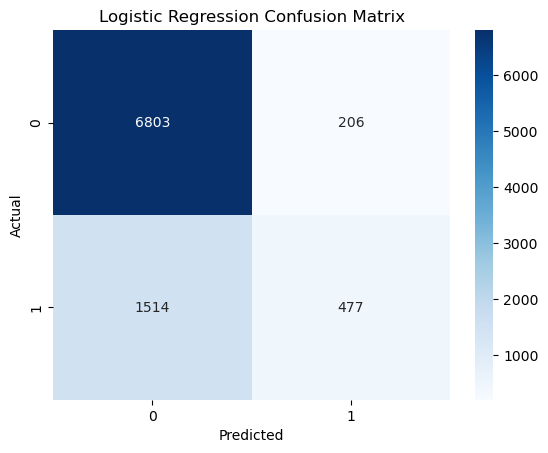

In [98]:
# confusion matrix for RF
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Confusion Matrix for XGBoost
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()


# confusion matrix for Logistic Regression 
sns.heatmap(confusion_matrix(y_test, log_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

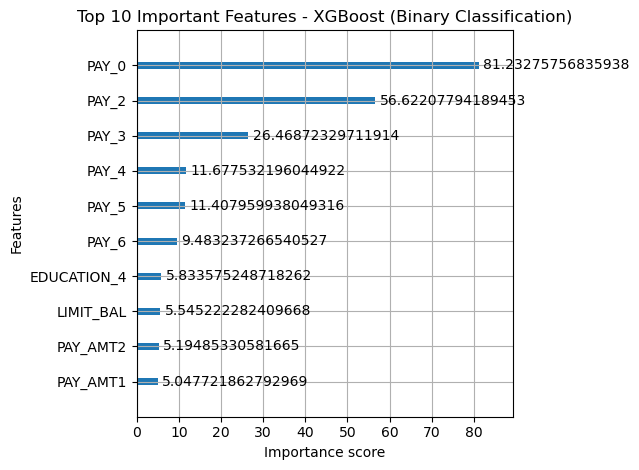

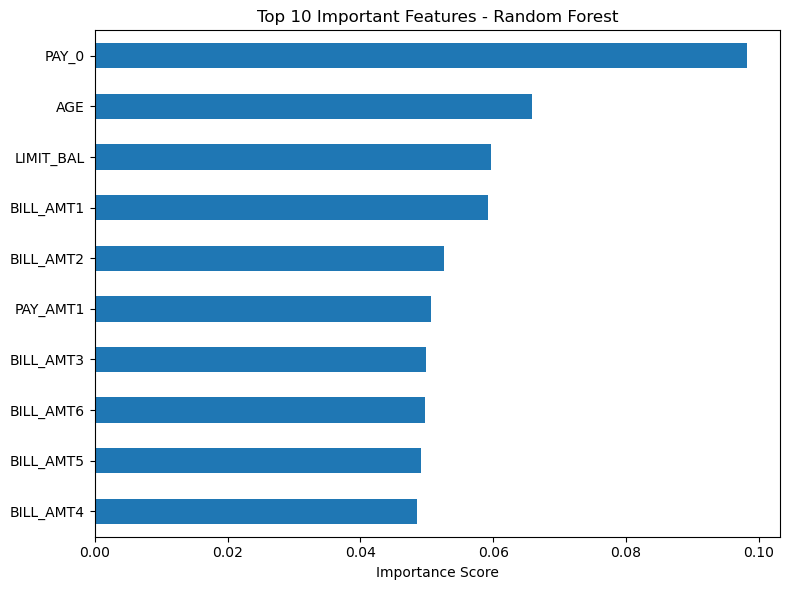

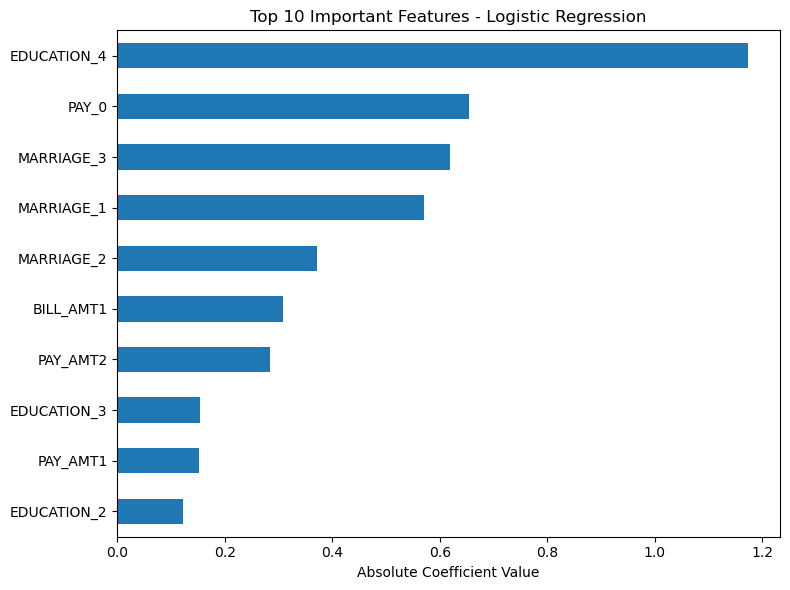

In [100]:
# === XGBoost Feature Importance ===
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features - XGBoost (Binary Classification)")
plt.tight_layout()
plt.show()

# === Random Forest Feature Importance ===

rf_importance = pd.Series(rf_model.feature_importances_, index=X_train_raw.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
rf_importance.plot(kind='barh')
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === Logistic Regression Feature Importance ===
log_importance_abs = pd.Series(log_model.coef_[0], index=X_train_norm.columns).abs().sort_values(ascending=False).head(10)


plt.figure(figsize=(8, 6))
log_importance_abs.plot(kind='barh')
plt.title("Top 10 Important Features - Logistic Regression")
plt.xlabel("Absolute Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [104]:
#  Import Libraries 
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical

#  Step 5.1: Load Cleaned (Unnormalized) Dataset 
df = pd.read_csv("cleaned_task1_dataset_NOT_Normalized.csv")  # Use raw version for tree-based models
X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

#  Step 5.2: Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#  Step 5.3: Define Genetic Algorithm Search Space
param_grid = {
    "n_estimators": Integer(50, 300),
    "max_depth": Integer(3, 20),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 10),
    "criterion": Categorical(["gini", "entropy"]),
}

#  Step 5.4: Setup Genetic Algorithm Search 
model = RandomForestClassifier(random_state=42)

evolved_rf = GASearchCV(
    estimator=model,
    cv=3,
    scoring='f1',
    param_grid=param_grid,
    population_size=10,
    generations=5,
    n_jobs=-1,
    verbose=True
)

#  Step 5.5: Fit Optimized Model 
evolved_rf.fit(X_train, y_train)

#  Step 5.6: Evaluate Optimized Model 
optimized_preds = evolved_rf.predict(X_test)
print("📈 Optimized Random Forest Report:")
print(classification_report(y_test, optimized_preds))

#  Step 5.7: Train and Evaluate Baseline Model 
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)
baseline_preds = baseline_rf.predict(X_test)

print("⚠️ Baseline Random Forest Report:")
print(classification_report(y_test, baseline_preds))

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.44783	0.0394253  	0.475492   	0.363004   
1  	20    	0.474264	0.00117388 	0.475563   	0.472092   
2  	20    	0.47519 	0.00114188 	0.477278   	0.473436   
3  	20    	0.476039	0.00086065 	0.477278   	0.474749   
4  	20    	0.476164	0.000747582	0.477278   	0.475563   
5  	20    	0.47677 	0.000648336	0.477278   	0.475563   
📈 Optimized Random Forest Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.35      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000

⚠️ Baseline Random Forest Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.64      0.36      0.46      1991

    accuracy                           0.81      90